In [42]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import random


In [43]:
train_data = pd.read_csv('data/train_processed.csv')
val_data = pd.read_csv('data/val.csv')

In [44]:
#Create a (prices, hour) df

hour_prices_df = train_data[['prices', 'hour']]
hours_prices={}
for hour in range(24):
    hour_prices=[]
    for index, row in hour_prices_df.iterrows():
        if int(row['hour'])==hour:
            hour_prices.append(row['prices'])
    hours_prices[hour] = hour_prices

In [45]:
df = pd.DataFrame.from_records(hours_prices)
df.describe(include="all")

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,...,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,38.838120,33.993558,30.053896,24.881168,23.124434,28.803768,36.652199,50.544790,56.924398,63.911743,...,58.981095,54.614881,53.981651,60.162509,67.466077,62.436697,58.464252,50.285712,50.451268,45.259334
std,21.884887,16.453507,15.947602,14.585498,14.436540,15.899613,20.775206,28.969477,30.775903,39.165093,...,39.279068,38.096263,40.691564,46.205986,75.780436,45.182318,77.865406,22.377123,20.360752,19.155459
min,0.010000,0.300000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,8.030000,1.000000,0.010000,0.010000,1.000000,10.410000,5.530000,8.360000,18.920000,16.090000
25%,25.407500,22.000000,19.007500,13.435000,11.237500,17.927500,21.977500,30.000000,34.982500,39.975000,...,37.615000,34.605000,33.602500,35.000000,36.040000,36.405000,35.905000,34.040000,35.085000,30.850000
50%,33.470000,29.465000,26.025000,21.685000,20.000000,25.725000,32.895000,43.590000,49.000000,52.715000,...,49.930000,46.850000,45.030000,49.895000,55.990000,55.825000,51.000000,43.545000,41.960000,37.395000
75%,52.850000,46.352500,40.717500,34.000000,31.942500,39.405000,52.187500,71.950000,76.775000,82.855000,...,75.000000,70.000000,69.567500,74.992500,80.792500,79.302500,73.017500,65.960000,66.465000,60.977500
max,500.000000,180.000000,200.000000,160.000000,160.000000,160.000000,150.500000,179.320000,227.130000,500.000000,...,950.000000,950.000000,950.000000,769.470000,1762.540000,1066.820000,2500.000000,300.030000,180.000000,210.100000


In [46]:
means=df.mean()
#From means we can say:
# 10 11 18 should be hours to sell
# 3 4 5 should be hours to buy


In [47]:
maxs=df.max()
maxs
#18 19 20

0      500.00
1      180.00
2      200.00
3      160.00
4      160.00
5      160.00
6      150.50
7      179.32
8      227.13
9      500.00
10     800.00
11     950.00
12     350.14
13     520.01
14     950.00
15     950.00
16     950.00
17     769.47
18    1762.54
19    1066.82
20    2500.00
21     300.03
22     180.00
23     210.10
dtype: float64

In [88]:
class Dam():

    def __init__(self, observation_data: pd.DataFrame):
        self.data = observation_data
        self.flow_rate = 18000
        self.sell_efficiency = 0.9
        self.buy_efficiency = 0.8
        self.water_capacity = self.flow_rate * 21
        self.conversion_factor = 1000 * 9.81 * 30 * (2 + (7/9)) * (10 ** -10)

    def _get_obs(self):
        self.hour = self.data["hour"].iloc[self.index]
        self.day = self.data["day"].iloc[self.index]
        self.week = self.data["week"].iloc[self.index]
        self.month = self.data["month"].iloc[self.index]
        self.electricity_cost = self.data["prices"].iloc[self.index]

        return {
            "time_hour": self.hour, 
            "time_day": self.day,
            "time_week": self.week,
            "time_month": self.month,
            "water_level": self.water_level,
            "electricity_cost": self.electricity_cost,
            "cash": self.cash,
            "value": self.value
        }
    
    def _get_info(self):
        return {
            "profit": (self.cash - self.starting_cash),
            "unrealized_profit": self.water_level * self.electricity_cost * self.sell_efficiency * self.conversion_factor,
            "total_value": (self.cash - self.starting_cash) + (self.water_level * self.electricity_cost * self.sell_efficiency * self.conversion_factor)
            }
    
    def step(self, action, terminated=False):
        info = self._get_info()
        previous_total_value = info["total_value"]
        # first check if simulation terminates, otherwise move index and perform action
        if (self.index+1) == self.data.shape[0] or (self.water_level == 0 and self.cash == 0):
            terminated = True
        else:
            # otherwise continue
            self.index += 1

            # we can only sell if there is water in the dam
            if action == 'sell' and self.water_level != 0:
                if self.water_level > self.flow_rate:
                    self.cash += self.electricity_cost * self.sell_efficiency * self.flow_rate*self.conversion_factor
                    self.water_level -= self.flow_rate
                else:
                    self.cash += self.electricity_cost * self.sell_efficiency * self.water_level*self.conversion_factor
                    self.water_level = 0
                    
            # we can only buy if we have cash and if dam is not full
            elif action == 'buy' and (self.water_level < self.water_capacity) and self.cash > (self.electricity_cost * self.sell_efficiency * (self.water_capacity - self.water_level) * self.conversion_factor):
                if (self.water_capacity - self.water_level) > self.flow_rate:
                    self.cash -= self.electricity_cost * self.buy_efficiency * self.flow_rate*self.conversion_factor
                    self.water_level += self.flow_rate
                else:
                    self.cash -= self.electricity_cost * self.sell_efficiency * (self.water_capacity - self.water_level)*self.conversion_factor
                    self.water_level = self.water_capacity
                    
        observation = self._get_obs()
        info = self._get_info()
        self.value = info["total_value"]
        if self.value > previous_total_value:
            reward = 1
        else:
            reward = -1
        return observation, reward, terminated, False, info

    def reset(self):
        self.index = 0
        self.hour = self.data["hour"].iloc[self.index]
        self.day = self.data["day"].iloc[self.index]
        self.week = self.data["week"].iloc[self.index]
        self.month = self.data["month"].iloc[self.index]

        self.water_level = 50000  # half of maximum water level
        self.starting_cash = 0  # (arbitrary) amount of cash
        self.cash = self.starting_cash
        self.electricity_cost = self.data["prices"].iloc[self.index]
        self.value = self.starting_cash + (self.electricity_cost * self.water_level)
        
        observation = self._get_obs()
        info = self._get_info()
        return observation, info


In [89]:
dam=Dam(val_data)
buy_hours=[3,4,5]
sell_hours=[10,11,18]
# 10 11 18 should be hours to sell
# 3 4 5 should be hours to buy

In [90]:
def evaluate():
    init_obs = dam.reset()
    rewards = 0
    action_sequence, cash, water_level, all_rewards = [], [], [], []
    for i in range(len(val_data)):
        obs = dam._get_obs()
        #buy with 0.3 prob
        if obs['time_hour'] in buy_hours :
        #and np.random.uniform(0,1) > 0.3:
            action='buy'
        elif obs['time_hour'] in sell_hours:
        # and np.random.uniform(0,1) > 0.3:
            action='sell'
        else:
            action='hold'
        action_sequence.append(action)
        next_state, reward, terminated, truncated, info = dam.step(action)
        rewards += reward
        water_level.append(next_state["water_level"])
        all_rewards.append(rewards)
        cash.append(info["profit"])

    print('The evaluation is done!')
    return action_sequence, cash, all_rewards, water_level

In [91]:
actions, cash, rewards, water_level = evaluate()

df = pd.DataFrame({"prices": val_data["prices"], 'actions': actions, "cash": cash, "water_level": water_level, "rewards": rewards})
df.to_csv('data/eval.csv')


The evaluation is done!


<AxesSubplot:>

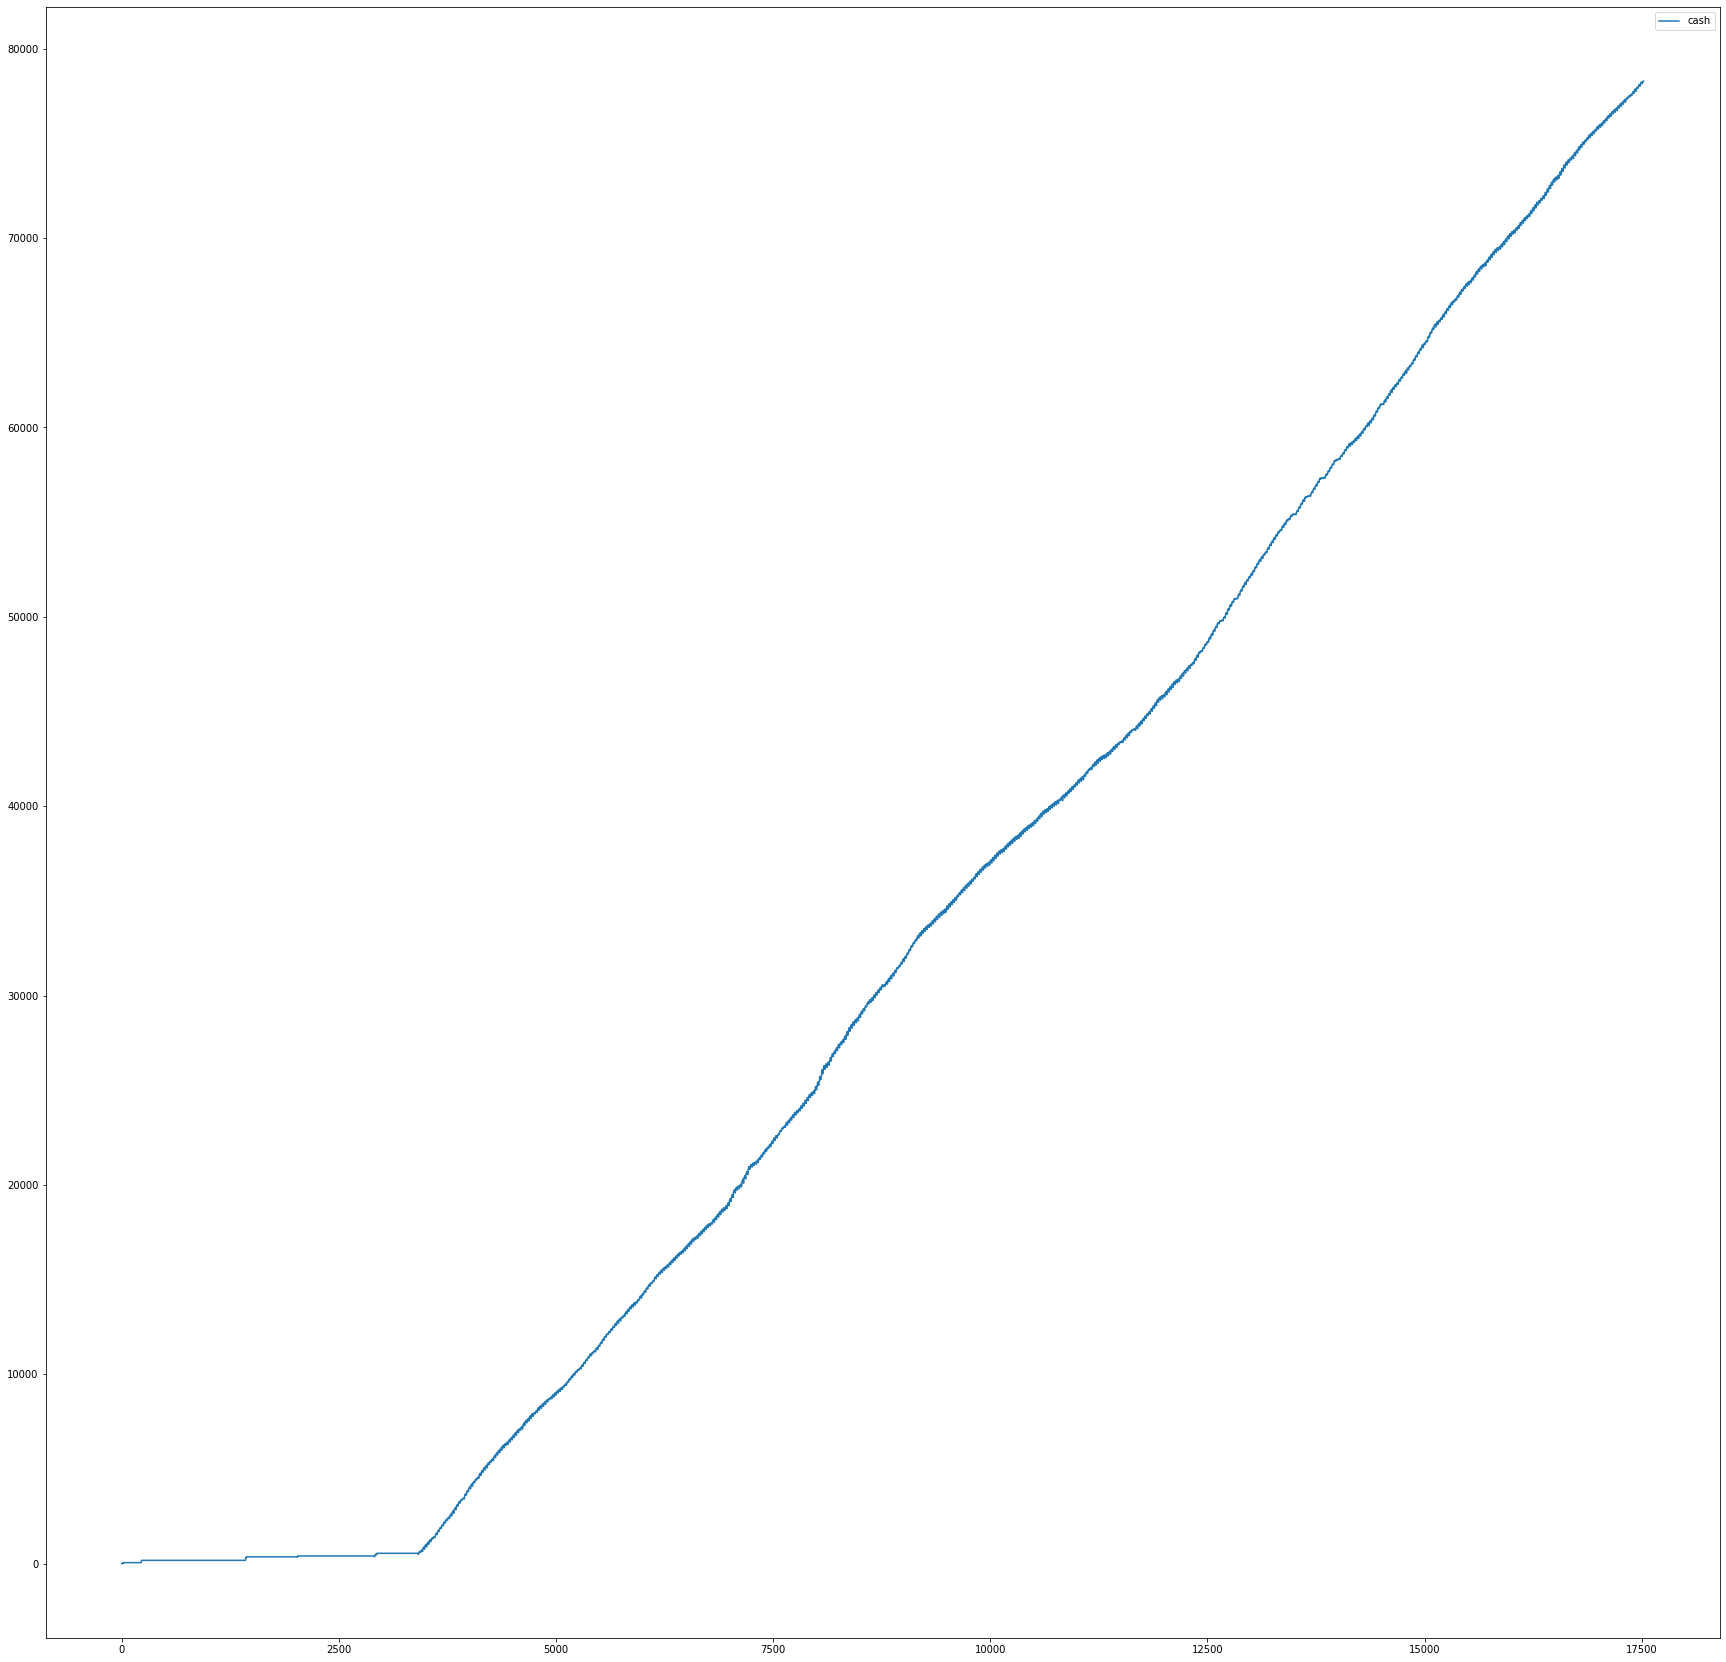

In [92]:
df.plot(x=None, y="cash", kind="line", figsize=(30, 30))